# **Reinforcement learning project: wind farm optimization**

**First part: MDP and optimal control**

Members:

* Kamgain Boris Tankam
* Ngoufack djoukang  Olivier vessah
* N'nane Dieudonné Junior
* Ntantame Petieu Stephen


Supervised by [Nicolas Gast](http://polaris.imag.fr/nicolas.gast/)

## Introduction


For this project, you work for a wind-farm company and you need to design the control algorithm
of a wind turbine. The wind turbine is located in a environnement in which the wind is hard to
predict. Your goal is to decide in real time of the angle of the turbine in order to maximize the energy
production while minimizing rotation costs. There are two parts in the project:
*  In the first part, we consider a simple stochastic model for which we know all parameters. You
need to solve this model by using the theory of Markov decision processes.

The objective of this project is to make you familiar with the tools that we learn in the course (MDPs
and RL algorithms), by applying them in a realistic example.


In most of the project, you control a single wind turbine for which you can control the angle of the
turbine. We assume that time is discrete at at each time instant, there are three control decisions that
you can apply: turn one degree left, turn one degree right and stay still. Turning left or right costs
you some energy but might help you produce more energy if you can get better aligned with the wind.
In the first part, we model the wind by a simple stochastic process and you will need to use MDP
theory to solve the problem optimally. In the second part, we only give access to a simulator and you
will need to implement RL based algorithms.


## Utils & Setup

In [4]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

In [5]:
def get_legends():
  COLOR_MAP = {'+1':10,'-1':100,'0':200}
  r = np.arange(0, 2, 0.01)
  theta = 2 * np.pi *r

  circle = [1.95 for _ in r]

  fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
  scatter = ax.scatter(theta, circle,c=[COLOR_MAP[random.choice(ACTIONS)] for angle in  theta])
  ax.set_rmax(2)
  ax.set_rticks([0.5])  # Less radial ticks
  ax.set_rlabel_position(-22.5)
  legends = scatter.legend_elements()
  plt.close()
  return legends[0]

def visualize(policy,legend="modify the title"):

  COLOR_MAP = {'+1':10,'-1':100,'0':200}
  r = np.arange(0, 2, 0.01)
  theta = 2 * np.pi *r

  circle = [1.95 for _ in r]

  fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
  scatter = ax.scatter(theta, circle,c=[COLOR_MAP[policy[int(angle*180/np.pi)%NUM_STATES]] for angle in  theta])
  ax.set_rmax(2)
  ax.set_rticks([0.5])  # Less radial ticks
  ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
  #ax.grid(True)
  
  # produce a legend with the unique colors from the scatter
  legend1 = ax.legend(get_legends(),['+1','-1','0'],
                      loc="lower left", title="Actions")
  ax.add_artist(legend1)


  ax.set_title(legend, va='bottom')
  plt.show()



## 1. Modelisation

**Question** :  Assume that $V$ is constant in time and equal to Vmax, and that moving left or right costs a unit
of energy. Model the problem as a MDP, and explain how to compute the optimal solution for
a given discount factor γ.

**Model the problem**

A MDP is defined by a tuple of $(S,A,P,R)$ and $γ$ (discount factor in an infinite particular case);so modelling this problem as a MDP consist of defining in this particular case what represent our state space S,our action set $A$,the markovian transitions $(P)$ and the rewards space.
- **state space $S$** : 
the set of possible angle between the wind direction and the turbine direction;that means $S = {0,1,2,......359}$.
- **Action set**: possible actions that we can decide to do in order to control our turbine(staying still that stand for action 0, turning one degree left that stand for action -1, and turning one degree right that stand for action +1)thus $A= {-1,0,+1}$.
- **The rewards space $R$** : we consider in this situation the rewards as the the energy earn in one time step when reaching that step(state)minus the cost related to the action that permit us to get into that state;it means $R(state,action)= f(v)cos(action)-∂a$ with $∂=1$ if action taken to reach to state s was either -1 or +1 and $∂=0 $ otherwise. and $ f(v)= v = 1 $ here.
- **The markovian transitions** : Here we explain how we found our probability of getting in a state given that from the previous state we choose a particular action.So since at each time step we assume that the wind orientation moves by plus or minus one degree, we model it as if given a certain action (0,-1,+1) that we decide to do on the turbine the wind has 50% of chances of moving by plus one degree and 50% of chances of moving by minus one degree. hence we obtain:

  $P(St+1 = k+1 / st = k,At = 0)\\
  = P(St+1 = k+2 / st = k,At = +1)\\
  = P(St+1 = k-1 / st = k,At = 0)\\
  = P(St+1 = k-2 / st = k,At = -1)\\
  = P(St+1 = k / st = k,At = -1)\\
  = P(St+1 = k / st = k,At = +1)=1/2.$


**How to compute the optimal solution**

after the previous modeling, it is clearly a question for us of proposing a policy to be adopted by our agent for each state where our system is located to maximize the energy gain (which we have modeled by the difference between the energy gained and the one lost by reaching the state).
Hence, we opt for a resolution based on the iteration value which consists in determining for each state the maximum function value after a large number of iterations of the algorithm until the value converges; after that we consider the actions which made it possible to obtain the maximum function values ​​which are those which reassure us that the accumulated energy is the most optimal possible; the set of this actions therefore constitutes our optimal policy and is therefore the optimal solution of our problem.



## 2. Implementation Algorithm Constant Speed

**Question** : Implement an algorithm that finds the optimal solution and illustrate the optimal solution. You
are free to choose your values of a and γ, but try to find ones that provide interesting results
(Hint: Choose a close to 0 and γ close to 1)

In [22]:
STATES = range(360) # degrees divided in buckets
ACTIONS = ['+1','-1','0']
NUM_STATES = len(STATES)
a_penalty = 0.2
V_max = 1
LAMBDA = 0.9

In [23]:
def f(v):
  assert(v>=0)
  return v**3 if v<=V_max else 0

In [24]:
def create_rewards(v,a_penalty=0.4):
  """
    Helper function to create reward per state and action
  """
  rewards = {} # key (s,a)
  for s in STATES:
    for action in ACTIONS:
      rewards[(s,action)]=f(v)*np.cos(s*np.pi/180)-abs(int(action))*a_penalty
  return rewards

rewards = create_rewards(1,a_penalty)
assert(k<360 and k>=0 for k in rewards.keys()) #verify everything is Ok

In [25]:
def create_probas():
  """
    Helper function to create transition probabilities
  """
  probas = {}
  for s in STATES :
    for action in ACTIONS:
      probas[(s,action)] = np.zeros(len(STATES))
      if action == '0':
        probas[(s,action)][(s+1)%NUM_STATES] = 1/2
        probas[(s,action)][(s-1)%NUM_STATES] = 1/2
      if action == '+1':
        probas[(s,action)][s] = 1/2
        probas[(s,action)][(s+2)%NUM_STATES] = 1/2
      if action == '-1':
        probas[(s,action)][s] = 1/2
        probas[(s,action)][(s-2)%NUM_STATES] = 1/2
  return probas

probas = create_probas()
assert(np.sum(probas[proba])==1 for proba in probas) #verify everything is Ok

In [26]:
class PolicyFinder:
  """
  Helper function to find optimal value of v
  """
  def __init__(self,rewards,probas):
    self.rewards = rewards
    self.probas = probas
  
  def solve(self,n_iter,lbd = 0.9):
    V = np.zeros(NUM_STATES,dtype=np.float64) # Initialisation V à 0
    for t in tqdm(range(n_iter)):
      V_copy = V.copy() # copie pour conserver l'état intact
      for s in STATES:
        V_copy[s] = max([rewards[(s,action)]+lbd*np.sum(V*self.probas[(s,action)]) for action in ACTIONS])
      V = V_copy.copy()
    return V

In [27]:
pf = PolicyFinder(rewards,probas)

In [28]:
logs = []
temp = 0
tests = list(range(10,150,10))
for i in tests:
  v = pf.solve(i)
  diff = np.linalg.norm(v-temp)
  temp = v.copy()
  logs.append(diff)

100%|██████████| 140/140 [00:01<00:00, 116.73it/s]


We plot norm difference between iterations to check **convergence**.

Text(0.5, 1.0, 'Norm of difference between successive values of V ')

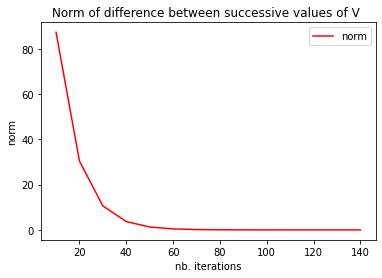

In [29]:
import matplotlib.pyplot as plt

plt.plot(tests,logs,color='red')
plt.legend(["norm"])
plt.ylabel("norm")
plt.xlabel("nb. iterations")
plt.title("Norm of difference between successive values of V ")


In [30]:
v_opt1 = pf.solve(50,lbd=LAMBDA)

100%|██████████| 50/50 [00:00<00:00, 111.61it/s]


In [31]:
def policy_returner(states,actions,values_opt):
  """
   returns policy in the form of a dictionary (state -> action)
  """
  policy = {}
  for s in states:
    best = -np.inf
    current = 0
    for a in actions:
      current = np.sum(probas[s,a]*values_opt)
      if current>best:
        best_action=a
        best = current
    policy[s]=best_action
  return policy

policy1 = policy_returner(STATES,ACTIONS,v_opt1)

Let's visualize **the learned policy**.



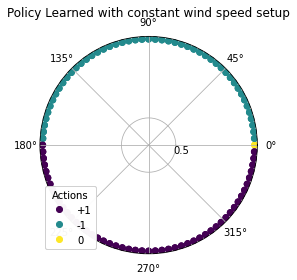

In [32]:
visualize(policy1,"Policy Learned with constant wind speed setup")

** Interpretation of the optimal solution** 

 According to the optimal policy plot above, it appears that the best actions to  do are:

- stay still if the angle between the turbine and the wind direction is zero which is reasonable since it is at this position that normally we produce the maximal energy and that we dont loose any amount of energy since we don't execute any action that have a cost of energy
- turning one degree left if the angle is found in between 1 and 180 : this is also reasonnable since the action contribute to reduce the angle and therefore to increase the energy earn ;this action is because the lost is less than the gain. with a  value of the penalty bigger  the policy will not be the same and will probable lead us to the action of staying still.
- turning one degree right if the angle is found in between 181 and 359: is also reasonnable since the action contribute to increase the angle and therefore to increase the energy earn ;this action is because the lost is less than the gain. with a  value of the penalty bigger the policy will not be the same and will probable lead us to the action of staying still.

## 3 Implementation Variable Speed

**Question** : Assume now that the wind at time t+ 1 evolves as V (t+ 1) = max(0, min(1.1, V (t) +b∆(t))),
where ∆(t) is a value uniformly distributed between −1 and 1 and b > 0 is a parameter. Redo
questions 1 and 2 above with the new model. Comment on the change of model that is needed.

In this case, we will consider the same MDP model as previously. 

The only thing we are changing here is our reward space $R$.

In effect, since now v is no more constant we apply here the function $f(v)cos(state)- ∂a$ as previously but now $f(v)$ is changing and given by $f(V ) = V^3$ if $V ≤ Vmax$ else $0$ with the fact that after each time step we compute the new value of the speed of the wind using the formula given: 
$V (t + 1) = max(0, min(1.1, V (t) + b∆(t)))$

with $∆(t)$ a random value that we generate randomly in beetween -1 and 1 and b a positive real number.


In [ ]:
class PolicyFinderVariableSpeed(PolicyFinder):
  """
  Helper function to find optimal value of v
  """
  def solve(self,n_iter,lbd=0.9,a_penalty=0.4):
    speed = 0.1
    b = 0.2
    V = np.zeros(NUM_STATES,dtype=np.float64) # Initialisation V à 0
    for t in tqdm(range(n_iter)):
      V_copy = V.copy() # copie pour conserver l'état intact
      for s in STATES:
        speed = max(0,min(1.1,speed+b*np.random.uniform(0,1)))
        V_copy[s] = max([f(speed)*np.cos(s*np.pi/180)-abs(int(action))*a_penalty+lbd*np.sum(V*self.probas[(s,action)]) for action in ACTIONS])
      V = V_copy.copy() # copie pour conserver l'état intact
    return V

In [ ]:
pf2 = PolicyFinderVariableSpeed(rewards,probas)

In [ ]:
logs = []
temp = 0
tests = list(range(10,70,5))
for i in tests:
  v = pf2.solve(i)
  diff = np.linalg.norm(v-temp)
  temp = v.copy()
  logs.append(diff)

100%|██████████| 65/65 [00:00<00:00, 83.57it/s]


Again, we p

Text(0.5, 1.0, 'Norm of difference between successive values of V ')

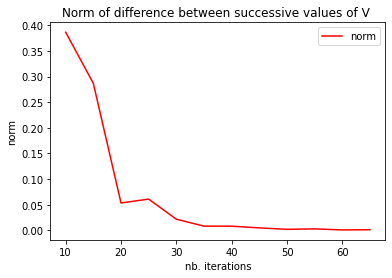

In [ ]:
import matplotlib.pyplot as plt

plt.plot(tests,logs,color='red')
plt.legend(["norm"])
plt.ylabel("norm")
plt.xlabel("nb. iterations")
plt.title("Norm of difference between successive values of V ")


In [ ]:
v_opt2 = pf2.solve(100,lbd=0.9,a_penalty=0.4)

100%|██████████| 100/100 [00:01<00:00, 83.24it/s]


In [ ]:
def policy_returner(states,actions,probas,values_opt):
  """
   returns policy in the form of a dictionary (state -> action)
  """
  policy = {}
  for s in states:
    best = -np.inf
    current = 0
    for a in actions:
      current = np.sum(probas[s,a]*values_opt)
      if current>best:
        best_action=a
        best = current
    policy[s]=best_action
  return policy

policy2 = policy_returner(STATES,ACTIONS,probas,v_opt2)

Let's visualize learned policy

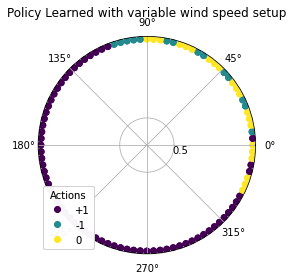

In [ ]:
visualize(policy2,"Policy Learned with variable wind speed setup")

**let's comment the results **

this representation of the optimal policy in the case we model the speed of the wind changing after each time speed is different with the first one which the speed v of the wind was constant; in effect the best action to do when we are in the state zero meaning that the angle between the wind direction and the turbine is zero is still to stay still which is still coherent as previously but for the others states the policy is different ; now we have a policy which is more real since the model now seems  more real because in practise we will not have the hand in controlling how the speed of the wind might change that is the reason why this model is more real and practical in a real situation.

## 4 Implementation Momentum 

**Question**: In addition to the above, assume that the wind has some momentum: with 90% chances, the
change in the orientation of the wind will be the same as the one during the last time step. Redo
question 1 and 2 above and comment.

In this case, we reconsider the MDP of the question (3-1) but with a different markovian transition. Here we have to find the probability of reaching to a state St+1 given an action At we applied from the previous state St, and the direction taken by the wind before reaching the state St. We denote as Wt the action taken by the wind at time t and we consider that Wt can be either +1 (the wind moved to the left direction, so increase the angle by 1) or -1 (the wind moved to the right direction, so decrease the angle by 1).
Hence, the markovian transition is obtained as following: 



$\\
P(St+1 = k+1 / st = k,At = 0, Wt-1=-1)=1/10 \\
P(St+1 = k+1 / st = k,At = 0, Wt-1=+1)=9/10\\
P(St+1 = k-1 / st = k,At = 0, Wt-1=-1)=9/10\\
P(St+1 = k-1 / st = k,At = 0, Wt-1=+1)=1/10\\
P(St+1 = k+2 / st = k,At = +1, Wt-1=-1)=1/10\\
P(St+1 = k+2 / st = k,At = +1, Wt-1=+1)=9/10\\
P(St+1 = k / st = k,At = +1, Wt-1=-1)=9/10\\
P(St+1 = k / st = k,At = +1, Wt-1=+1)=1/10\\
P(St+1 = k-2 / st = k,At = -1, Wt-1=-1)=9/10\\
P(St+1 = k-2 / st = k,At = -1, Wt-1=+1)=1/10\\
P(St+1 = k / st = k,At = -1, Wt-1=-1)=1/10\\
P(St+1 = k / st = k,At = -1, Wt-1=-1)=9/10\\
$

In [ ]:
def create_probas3():
  """
  Helper function to create transition probabilities
  """
  probas = {}
  i=0
  #print(list(states))
  for s in STATES:
    #print(s1,"t")
    for action in ACTIONS:
     #pass
      for p_wind in ['-1','+1']:
        probas[(s,action,p_wind)] = np.zeros(len(STATES))
        i+=1
        if action == '0' and p_wind=='+1':
          probas[(s,action,p_wind)][(s+1)%NUM_STATES] = 9/10 #ATTENTION MODULO
          probas[(s,action,p_wind)][(s-1)%NUM_STATES] = 1/10
          #probas[(s,action)][(s-1)%NUM_STATES] = 1/2
        if action == '0' and p_wind=='-1':
          probas[(s,action,p_wind)][(s+1)%NUM_STATES] = 1/10 #ATTENTION MODULO
          probas[(s,action,p_wind)][(s-1)%NUM_STATES] = 9/10
          #probas[(s,action)][(s-1)%NUM_STATES] = 1/2
        if action == '+1' and p_wind=='+1':
          probas[(s,action,p_wind)][(s+2)%NUM_STATES] = 1/10 #ATTENTION MODULO
          probas[(s,action,p_wind)][(s)%NUM_STATES] = 9/10
        if action == '+1' and p_wind=='-1':
          probas[(s,action,p_wind)][(s+2)%NUM_STATES] = 9/10 #ATTENTION MODULO
          probas[(s,action,p_wind)][(s)%NUM_STATES] = 1/10
        if action == '-1' and p_wind=='+1':
          probas[(s,action,p_wind)][(s-2)%NUM_STATES] = 9/10 #ATTENTION MODULO
          probas[(s,action,p_wind)][(s)%NUM_STATES] = 1/10
        if action == '-1' and p_wind=='-1':
          probas[(s,action,p_wind)][(s-2)%NUM_STATES] = 1/10 #ATTENTION MODULO
          probas[(s,action,p_wind)][(s)%NUM_STATES] = 9/10
    #print(i)
  return probas

probas3 = create_probas3()
assert(np.sum(probas[proba])==1 for proba in probas)

In [ ]:
len(probas3.keys())

2160

In [ ]:
class PolicyFinderVariableMomentum(PolicyFinder):
  """
    Helper function to find optimal value of v
  """
  def solve(self,n_iter,lbd=0.9,speed_initial=0.1,b = 0.3,a_penalty=0.4):
    speed = speed_initial
    V = np.zeros(NUM_STATES,dtype=np.float64) # Initialisation V à 0
    for t in tqdm(range(n_iter)):
      V_copy = V.copy() # copie pour conserver l'état intact
      for s in STATES:
        speed = max(0,min(1.1,speed+b*np.random.uniform(0,1)))
        V_copy[s] = max([f(speed)*np.cos(s*np.pi/180)-abs(int(action))*a_penalty+lbd*np.sum(V*self.probas[(s,action,p_wind)]) for action in ACTIONS for p_wind in ['-1','+1']])
      V = V_copy.copy() # copie pour conserver l'état intact
    return V

In [ ]:
pf3 = PolicyFinderVariableMomentum(rewards,probas3)

In [ ]:
logs = []
temp = 0
tests = list(range(10,120,10))
for i in tests:
  v = pf3.solve(i)
  diff = np.linalg.norm(v-temp)
  temp = v.copy()
  logs.append(diff)

100%|██████████| 110/110 [00:02<00:00, 45.36it/s]


Text(0.5, 1.0, 'Norm of difference between successive values of V ')

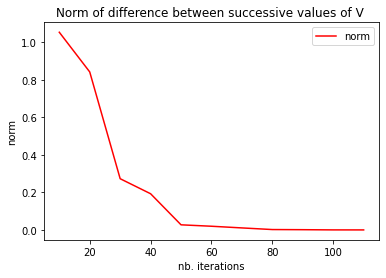

In [ ]:
import matplotlib.pyplot as plt

plt.plot(tests,logs,color='red')
plt.legend(["norm"])
plt.ylabel("norm")
plt.xlabel("nb. iterations")
plt.title("Norm of difference between successive values of V ")


In [ ]:
v_opt3 = pf3.solve(300)

100%|██████████| 300/300 [00:06<00:00, 43.94it/s]


In [ ]:
def policy_returner3(states,actions,probas,values_opt):
  """
   returns policy in the form of a dictionary (state -> action)
  """
  policy = {}
  for s in states:
    best = -np.inf
    current = 0
    for a in actions:
      current = np.sum(probas[(s,a,'+1')]*values_opt+probas[(s,a,'-1')]*values_opt)
      if current>best:
        best_action=a
        best = current
    policy[s]=best_action
  return policy

policy3 = policy_returner3(STATES,ACTIONS,probas3,v_opt3)


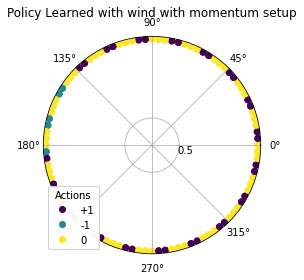

In [ ]:
visualize(policy3,"Policy Learned with wind with momentum setup")

**let's comment and interpret the results**

According to the representation of the optimal policy above , it appears that in most cases the best actions to do is to stay still with the last model ; in effect this model combine the previous one (question 3) and add an other consideration which is interresting in such a way that it inform us that the wind has more chances (90 %)to keep its previous change in direction from one time step to the next one.this modelisation is obviously mostly similar to what we can observe in a real situation. 
